<a href="https://colab.research.google.com/github/JasperAD11/Sentiment-Across-Signals-Neural-Networks-vs.-LLMs/blob/main/final_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1

## Libraries and GloVe

In [ ]:
import tensorflow as tf
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, models, initializers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import TextVectorization, Input, Embedding, LSTM, Dropout, Dense
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Get GloVe from the web
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-05-15 13:15:21--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-15 13:15:21--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-15 13:15:21--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

## Binary model

### Dataset

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  54.5M      0  0:00:01  0:00:01 --:--:-- 54.5M


In [ ]:
# Directory path
dataset_dir = "aclImdb"

# Remove unsup data (not labeled)
shutil.rmtree(os.path.join(dataset_dir, 'train', 'unsup'))

# Load training and test sets
batch_size = 32
seed = 42

train_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed
)

val_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed
)

test_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, "test"),
    batch_size=batch_size
)

# To train the Final Model
full_train_ds = train_ds.concatenate(val_ds).shuffle(10000)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
max_vocab = 20000
sequence_len = 300

vectorizer = TextVectorization(
    max_tokens=max_vocab,
    output_mode='int',
    output_sequence_length=sequence_len
)

# Adapt vectorizer on training data
text_only_train = train_ds.map(lambda x, y: x)
vectorizer.adapt(text_only_train)

In [ ]:
# Convert datasets to NumPy arrays or tensors
def vectorize_dataset(ds):
    return ds.map(lambda x, y: (vectorizer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = vectorize_dataset(train_ds)
val_ds = vectorize_dataset(val_ds)
test_ds = vectorize_dataset(test_ds)
full_train_ds = vectorize_dataset(full_train_ds)


### Model 1
val_accuracy = 0.8772

In [ ]:
model1 = keras.Sequential([
    layers.Embedding(input_dim=max_vocab, output_dim=128),
#    layers.GlobalAveragePooling1D(),      # either this
    layers.GlobalMaxPooling1D(),           # or this
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
    ])

model1.compile(optimizer="adam",
               loss="binary_crossentropy",
               metrics=["accuracy"])

In [ ]:
history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

model1.summary()

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.7163 - loss: 0.5647 - val_accuracy: 0.8612 - val_loss: 0.3214
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.8949 - loss: 0.2535 - val_accuracy: 0.8784 - val_loss: 0.2929
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.9497 - loss: 0.1406 - val_accuracy: 0.8748 - val_loss: 0.3331
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.9855 - loss: 0.0523 - val_accuracy: 0.8744 - val_loss: 0.4049
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.9985 - loss: 0.0105 - val_accuracy: 0.8748 - val_loss: 0.4419


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 300)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 300, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,687,061 (29.32 MB)

 Trainable params: 2,562,353 (9.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,124,708 (19.55 MB)

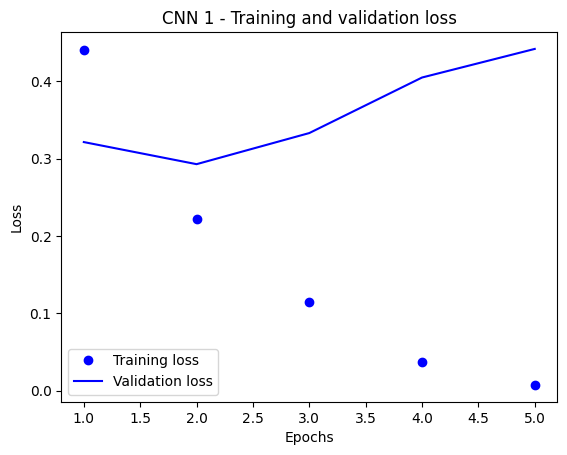

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("CNN 1 - Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

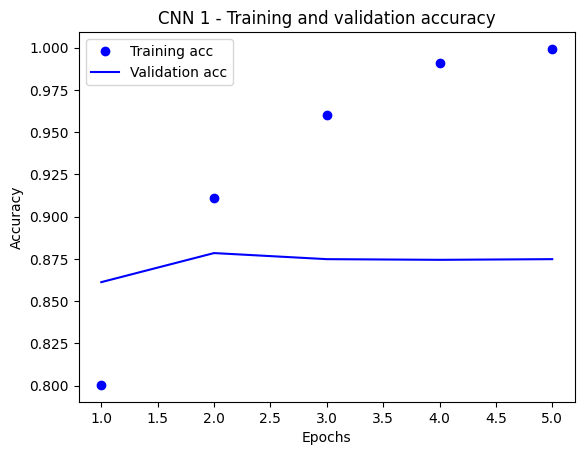

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("CNN 1 - Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Model 2
val_accuracy = 0.8870

In [ ]:
model2 = keras.Sequential([
    layers.Embedding(input_dim=max_vocab, output_dim=128),
    layers.GlobalAveragePooling1D(),  # Sequence → single vector    TEST WITHOUT

    # Dense layer 1
    layers.Dense(8, activation='relu'),

    # Dense layer 2
    layers.Dense(8, activation='relu'),

    # Dense layer 3 (Output)
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

model2.summary()

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.6175 - loss: 0.6327 - val_accuracy: 0.7790 - val_loss: 0.4380
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.8542 - loss: 0.3393 - val_accuracy: 0.8452 - val_loss: 0.3457
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - accuracy: 0.8943 - loss: 0.2615 - val_accuracy: 0.8780 - val_loss: 0.3048
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.9100 - loss: 0.2237 - val_accuracy: 0.8884 - val_loss: 0.2796
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.9374 - loss: 0.1719 - val_accuracy: 0.8844 - val_loss: 0.2940
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.9478 - loss: 0.1474 - val_accuracy: 0.8802 - val_loss: 0.3143
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.9578 - loss: 0.1173 - val_accuracy: 0.8806 - val_loss: 0.3389


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 300)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 300, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,683,341 (29.31 MB)

 Trainable params: 2,561,113 (9.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,122,228 (19.54 MB)

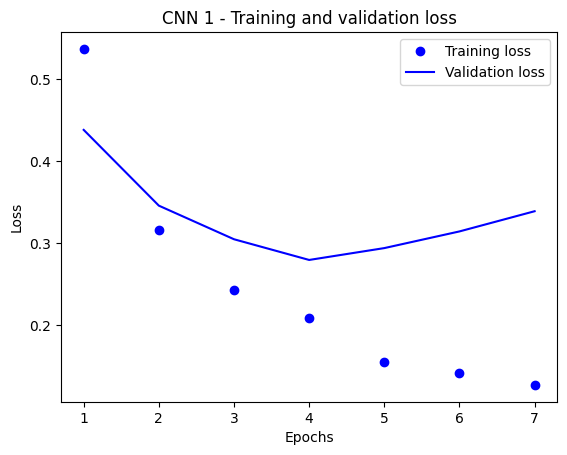

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("CNN 1 - Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

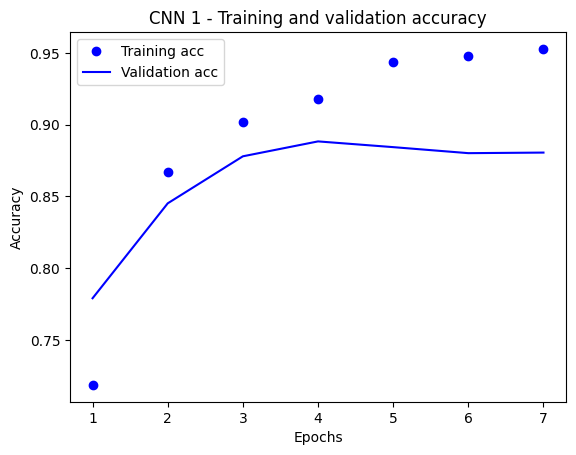

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("CNN 1 - Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Model 3
val_accuracy = 0.8720

In [ ]:
embedding_dim = 100
glove_path = "glove.6B.100d.txt"

# Load GloVe
embeddings_index = {}
with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

# Create embedding matrix
vocab = vectorizer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))

embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
model3 = models.Sequential([
    layers.Embedding(
        input_dim=len(vocab),
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False
    ),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),  # Stronger signal
    layers.GlobalMaxPooling1D(),  # Focus on the most important time steps
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

model3.summary()

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 223s 349ms/step - accuracy: 0.6523 - loss: 0.5968 - val_accuracy: 0.8266 - val_loss: 0.3777
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 351ms/step - accuracy: 0.8403 - loss: 0.3756 - val_accuracy: 0.8532 - val_loss: 0.3294
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 260s 348ms/step - accuracy: 0.8694 - loss: 0.3179 - val_accuracy: 0.8660 - val_loss: 0.3084
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 268s 358ms/step - accuracy: 0.8895 - loss: 0.2774 - val_accuracy: 0.8630 - val_loss: 0.3194
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 359ms/step - accuracy: 0.9065 - loss: 0.2451 - val_accuracy: 0.8684 - val_loss: 0.3146
Epoch 6/30
335/625 ━━━━━━━━━━━━━━━━━━━━ 1:35 329ms/step - accuracy: 0.9186 - loss: 0.2117

KeyboardInterrupt: 

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("CNN 1 - Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("CNN 1 - Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Final Binary Model (model 2)

In [ ]:
model_binary = keras.Sequential([
    layers.Embedding(input_dim=max_vocab, output_dim=128),
    layers.GlobalAveragePooling1D(),  # Sequence → single vector    TEST WITHOUT

    # Dense layer 1
    layers.Dense(8, activation='relu'),

    # Dense layer 2
    layers.Dense(8, activation='relu'),

    # Dense layer 3 (Output)
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model_binary.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model_binary.fit(
    full_train_ds,
    validation_data = test_ds,
    epochs=20,
    callbacks = [
        EarlyStopping(monitor='val_AUC', patience=10, restore_best_weights=True, mode='max'),
        ModelCheckpoint('best_model_binary.h5', monitor='val_accuracy', save_best_only=True, mode='max')]
)

model_binary.summary()

Epoch 1/20
772/782 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6064 - loss: 0.6373

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_AUC` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.6080 - loss: 0.6358 - val_accuracy: 0.7710 - val_loss: 0.4717
Epoch 2/20
778/782 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8629 - loss: 0.3242

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8630 - loss: 0.3240 - val_accuracy: 0.7958 - val_loss: 0.4660
Epoch 3/20
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8992 - loss: 0.2490

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8992 - loss: 0.2490 - val_accuracy: 0.7988 - val_loss: 0.4944
Epoch 4/20
772/782 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9184 - loss: 0.2072

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9185 - loss: 0.2070 - val_accuracy: 0.7996 - val_loss: 0.5341
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9329 - loss: 0.1800 - val_accuracy: 0.7720 - val_loss: 0.6903
Epoch 6/20
764/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9340 - loss: 0.1753

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9341 - loss: 0.1751 - val_accuracy: 0.8478 - val_loss: 0.3757
Epoch 7/20
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9492 - loss: 0.1425

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9492 - loss: 0.1425 - val_accuracy: 0.8545 - val_loss: 0.3812
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9545 - loss: 0.1287 - val_accuracy: 0.8458 - val_loss: 0.4469
Epoch 9/20
767/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9568 - loss: 0.1220

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9567 - loss: 0.1221 - val_accuracy: 0.8654 - val_loss: 0.4095
Epoch 10/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9624 - loss: 0.1104 - val_accuracy: 0.8625 - val_loss: 0.4457
Epoch 11/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9648 - loss: 0.1041 - val_accuracy: 0.8581 - val_loss: 0.4863
Epoch 12/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9585 - loss: 0.1123 - val_accuracy: 0.8484 - val_loss: 0.5431
Epoch 13/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9558 - loss: 0.1146 - val_accuracy: 0.8460 - val_loss: 0.5848
Epoch 14/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9568 - loss: 0.1121 - val_accuracy: 0.8439 - val_loss: 0.6059
Epoch 15/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9568 - loss: 0.1114 - val_accuracy: 0.8036 - val_loss: 0.8532
Epoch 16/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9546 - loss: 0.1146 - val_accuracy: 0.8340

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,683,341 (29.31 MB)

 Trainable params: 2,561,113 (9.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,122,228 (19.54 MB)

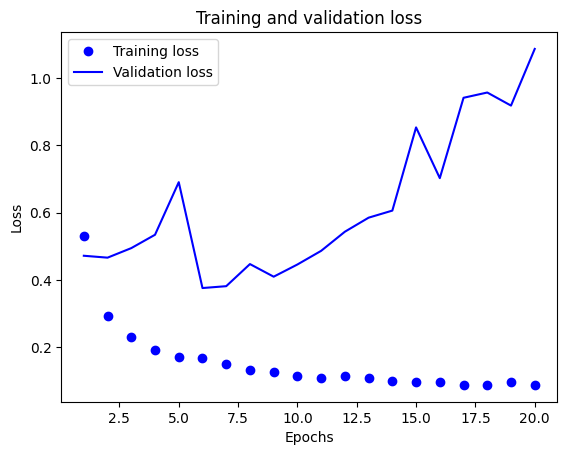

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

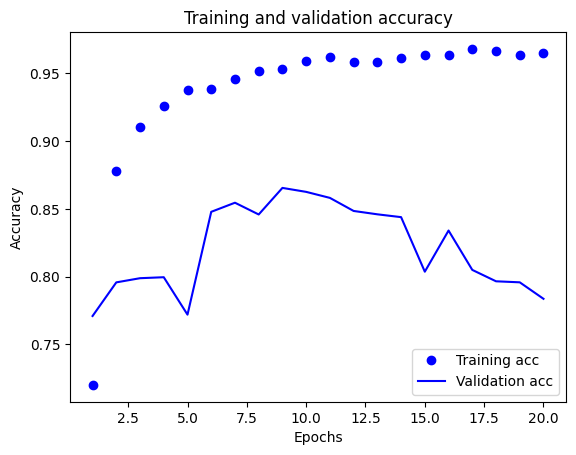

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# def predict_binary(text):
#    text_tensor = tf.convert_to_tensor([text])
#    pred = model_binary.predict(text_tensor)[0][0]
#    return "positive" if pred >= 0.5 else "negative"

# print(predict_binary("The direction and cinematography were absolutely brilliant."))
# print(predict_binary("So bad I would watch it again."))
# print(predict_binary("Bad."))
# print(predict_binary("I did not like it."))

## Multi-class model

### Dataset

In [ ]:
# Unzip to a folder
!unzip emotions-goemotions.zip -d emotions_data

Archive:  emotions-goemotions.zip
   creating: emotions_data/goemotions/
  inflating: emotions_data/goemotions/.DS_Store  
  inflating: emotions_data/__MACOSX/goemotions/._.DS_Store  
   creating: emotions_data/goemotions/data/
  inflating: emotions_data/__MACOSX/goemotions/._data  
  inflating: emotions_data/goemotions/data/.DS_Store  
  inflating: emotions_data/__MACOSX/goemotions/data/._.DS_Store  
   creating: emotions_data/goemotions/data/full_dataset/
  inflating: emotions_data/__MACOSX/goemotions/data/._full_dataset  
  inflating: emotions_data/goemotions/data/full_dataset/goemotions_1.csv  
  inflating: emotions_data/__MACOSX/goemotions/data/full_dataset/._goemotions_1.csv  
  inflating: emotions_data/goemotions/data/full_dataset/goemotions_3.csv  
  inflating: emotions_data/goemotions/data/full_dataset/goemotions_2.csv  


In [ ]:
dataset = pd.read_csv('emotions_data/goemotions/data/full_dataset/goemotions_1.csv')

In [ ]:
dataset.drop(columns=["id","author","subreddit","link_id","parent_id","created_utc","rater_id","example_very_unclear"], inplace=True)

In [ ]:
# vectorizer.adapt(dataset['text'].values)

X = vectorizer(dataset['text'].values)

y = dataset.drop(columns=['text'])

In [ ]:
X_numpy = X.numpy() if isinstance(X, tf.Tensor) else X
X_train_full, X_test, y_train_full, y_test = train_test_split(X_numpy, y, test_size=0.2, random_state=42)

# Second split: Take 20% of training for validation (16% of original)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=42
)

### Model 4

In [ ]:
max_tokens = len(vocab)  # Size of vocabulary
embedding_dim = 100       # Must match your embedding_matrix dimension

# Create model with CNN and LSTM layers
model4 = models.Sequential([
    layers.Embedding(input_dim=max_tokens,
                     output_dim=embedding_dim,
                     embeddings_initializer=initializers.Constant(embedding_matrix),
                     trainable=False),

    layers.Conv1D(128, 5, activation='relu'),  # CNN layer with 128 filters and kernel size 5
    layers.MaxPooling1D(2),  # Max pooling to downsample

    layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
    layers.GlobalMaxPooling1D(),  # Global max pooling to reduce dimensionality

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(y_train.shape[1], activation='sigmoid')
])


In [ ]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC'])

In [ ]:
# Fit the model
history = model4.fit(X_train,
                     y_train,
                     validation_data=(X_val, y_val),
                     epochs=20,
                     batch_size=64,callbacks=[
                        tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=3, restore_best_weights=True)]
                     )

model4.summary()

Epoch 1/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 508s 708ms/step - AUC: 0.6078 - loss: 0.2425 - val_AUC: 0.7340 - val_loss: 0.1579
Epoch 2/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 501s 709ms/step - AUC: 0.6916 - loss: 0.1658 - val_AUC: 0.7345 - val_loss: 0.1574
Epoch 3/20
522/700 ━━━━━━━━━━━━━━━━━━━━ 1:52 630ms/step - AUC: 0.6993 - loss: 0.1631

KeyboardInterrupt: 

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["AUC"]
val_acc = history_dict["val_AUC"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Model 5

In [ ]:
model5 = keras.Sequential([
    layers.Embedding(input_dim=max_vocab, output_dim=128),
    layers.GlobalAveragePooling1D(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(28, activation='sigmoid')
])

In [ ]:
model5.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['AUC'])

In [ ]:
history = model5.fit(X_train, y_train,
                     epochs=50,
                     batch_size=32,
                     validation_data=(X_val, y_val),
                     callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=10, restore_best_weights=True)
)
model5.summary()

Epoch 1/50
 641/1400 ━━━━━━━━━━━━━━━━━━━━ 26s 35ms/step - AUC: 0.6772 - loss: 0.1700

KeyboardInterrupt: 

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("CNN 1 - Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["AUC"]
val_acc = history_dict["val_AUC"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("CNN 1 - Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Final Multi-class Model (model 5)

In [ ]:
model_multi_class = keras.Sequential([
    layers.Embedding(input_dim=max_vocab, output_dim=128),
    layers.GlobalAveragePooling1D(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(28, activation='sigmoid')
])

model_multi_class.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['AUC'])

In [ ]:
history = model_multi_class.fit(X_train_full,
                                y_train_full,
                                epochs=50,
                                batch_size=32,
                                validation_data=(X_val, y_val),
                                callbacks = [
                                    EarlyStopping(monitor='val_AUC', patience=10, restore_best_weights=True),
                                    ModelCheckpoint('best_model_multi.h5', monitor='val_AUC', save_best_only=True, mode='max')]
)
model_multi_class.summary()

Epoch 1/50
1749/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6629 - loss: 0.1919

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - AUC: 0.6630 - loss: 0.1918 - val_AUC: 0.7320 - val_loss: 0.1571
Epoch 2/50
1744/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7134 - loss: 0.1598

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7134 - loss: 0.1598 - val_AUC: 0.7325 - val_loss: 0.1572
Epoch 3/50
1742/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7187 - loss: 0.1585

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.7187 - loss: 0.1585 - val_AUC: 0.7351 - val_loss: 0.1568
Epoch 4/50
1739/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7264 - loss: 0.1573

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7264 - loss: 0.1573 - val_AUC: 0.7362 - val_loss: 0.1574
Epoch 5/50
1749/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7318 - loss: 0.1570

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.7318 - loss: 0.1570 - val_AUC: 0.7386 - val_loss: 0.1569
Epoch 6/50
1741/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7452 - loss: 0.1549

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.7452 - loss: 0.1549 - val_AUC: 0.7678 - val_loss: 0.1514
Epoch 7/50
1747/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7580 - loss: 0.1524

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.7580 - loss: 0.1524 - val_AUC: 0.7860 - val_loss: 0.1475
Epoch 8/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7661 - loss: 0.1506 - val_AUC: 0.7771 - val_loss: 0.1489
Epoch 9/50
1749/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7762 - loss: 0.1484

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - AUC: 0.7762 - loss: 0.1484 - val_AUC: 0.7948 - val_loss: 0.1455
Epoch 10/50
1740/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7779 - loss: 0.1485

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7779 - loss: 0.1485 - val_AUC: 0.7964 - val_loss: 0.1455
Epoch 11/50
1749/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7853 - loss: 0.1468

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7854 - loss: 0.1468 - val_AUC: 0.8045 - val_loss: 0.1433
Epoch 12/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - AUC: 0.7928 - loss: 0.1455 - val_AUC: 0.8024 - val_loss: 0.1455
Epoch 13/50
1734/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7988 - loss: 0.1441

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7988 - loss: 0.1441 - val_AUC: 0.8073 - val_loss: 0.1426
Epoch 14/50
1743/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7980 - loss: 0.1441

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7980 - loss: 0.1441 - val_AUC: 0.8187 - val_loss: 0.1413
Epoch 15/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8024 - loss: 0.1431 - val_AUC: 0.8127 - val_loss: 0.1421
Epoch 16/50
1742/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8048 - loss: 0.1429

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8048 - loss: 0.1429 - val_AUC: 0.8295 - val_loss: 0.1391
Epoch 17/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8107 - loss: 0.1414 - val_AUC: 0.8098 - val_loss: 0.1433
Epoch 18/50
1734/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8127 - loss: 0.1410

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.8127 - loss: 0.1410 - val_AUC: 0.8307 - val_loss: 0.1375
Epoch 19/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8171 - loss: 0.1402 - val_AUC: 0.8276 - val_loss: 0.1389
Epoch 20/50
1736/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8184 - loss: 0.1395

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8184 - loss: 0.1395 - val_AUC: 0.8395 - val_loss: 0.1354
Epoch 21/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - AUC: 0.8218 - loss: 0.1386 - val_AUC: 0.8374 - val_loss: 0.1365
Epoch 22/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8239 - loss: 0.1384 - val_AUC: 0.8363 - val_loss: 0.1356
Epoch 23/50
1747/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8285 - loss: 0.1373

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8285 - loss: 0.1373 - val_AUC: 0.8465 - val_loss: 0.1334
Epoch 24/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8262 - loss: 0.1375 - val_AUC: 0.8462 - val_loss: 0.1334
Epoch 25/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8320 - loss: 0.1366 - val_AUC: 0.8431 - val_loss: 0.1342
Epoch 26/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - AUC: 0.8322 - loss: 0.1359 - val_AUC: 0.8415 - val_loss: 0.1346
Epoch 27/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - AUC: 0.8315 - loss: 0.1364 - val_AUC: 0.8414 - val_loss: 0.1341
Epoch 28/50
1735/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8369 - loss: 0.1351

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.8368 - loss: 0.1351 - val_AUC: 0.8553 - val_loss: 0.1309
Epoch 29/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - AUC: 0.8390 - loss: 0.1342 - val_AUC: 0.8517 - val_loss: 0.1338
Epoch 30/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8394 - loss: 0.1342 - val_AUC: 0.8522 - val_loss: 0.1327
Epoch 31/50
1748/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8396 - loss: 0.1344

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8396 - loss: 0.1344 - val_AUC: 0.8559 - val_loss: 0.1309
Epoch 32/50
1740/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8419 - loss: 0.1337

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8419 - loss: 0.1337 - val_AUC: 0.8621 - val_loss: 0.1290
Epoch 33/50
1735/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8455 - loss: 0.1324

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8455 - loss: 0.1324 - val_AUC: 0.8673 - val_loss: 0.1283
Epoch 34/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8433 - loss: 0.1332 - val_AUC: 0.8668 - val_loss: 0.1283
Epoch 35/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8456 - loss: 0.1327 - val_AUC: 0.8538 - val_loss: 0.1306
Epoch 36/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8464 - loss: 0.1327 - val_AUC: 0.8662 - val_loss: 0.1304
Epoch 37/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - AUC: 0.8474 - loss: 0.1320 - val_AUC: 0.8590 - val_loss: 0.1295
Epoch 38/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.8493 - loss: 0.1313 - val_AUC: 0.8672 - val_loss: 0.1271
Epoch 39/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8498 - loss: 0.1318 - val_AUC: 0.8633 - val_loss: 0.1293
Epoch 40/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8525 - loss: 0.1310 - val_AUC: 0.8559 - val_loss: 0.1308
Epoch 41/50
1739/1750 ━━━━━━━━━━━━━━━━━━━━

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - AUC: 0.8547 - loss: 0.1298 - val_AUC: 0.8700 - val_loss: 0.1302
Epoch 42/50
1747/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8567 - loss: 0.1293

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8567 - loss: 0.1293 - val_AUC: 0.8704 - val_loss: 0.1260
Epoch 43/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8543 - loss: 0.1304

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8543 - loss: 0.1304 - val_AUC: 0.8709 - val_loss: 0.1268
Epoch 44/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8590 - loss: 0.1289 - val_AUC: 0.8624 - val_loss: 0.1292
Epoch 45/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8600 - loss: 0.1286 - val_AUC: 0.8552 - val_loss: 0.1300
Epoch 46/50
1738/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8585 - loss: 0.1286

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - AUC: 0.8585 - loss: 0.1286 - val_AUC: 0.8744 - val_loss: 0.1245
Epoch 47/50
1745/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8633 - loss: 0.1276

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8633 - loss: 0.1276 - val_AUC: 0.8781 - val_loss: 0.1237
Epoch 48/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - AUC: 0.8622 - loss: 0.1276 - val_AUC: 0.8596 - val_loss: 0.1286
Epoch 49/50
1739/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8624 - loss: 0.1279

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.8624 - loss: 0.1279 - val_AUC: 0.8790 - val_loss: 0.1242
Epoch 50/50
1744/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8643 - loss: 0.1268

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - AUC: 0.8643 - loss: 0.1268 - val_AUC: 0.8802 - val_loss: 0.1226


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (32, 300, 128)         │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (32, 128)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 128)              │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 28)               │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,759,766 (29.60 MB)

 Trainable params: 2,586,588 (9.87 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,173,178 (19.73 MB)

## Merging **Binary** and **Multi class** models

In [ ]:
# Define emotion labels (adjust to your actual labels)
emotion_labels = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity',
                  'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
                  'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
                  'remorse', 'sadness', 'surprise', 'neutral']

def predict_text(text, threshold=0.3):
    # Convert to batch shape and vectorize
    input_text = tf.convert_to_tensor([text])
    vectorized = vectorizer(input_text)

    # Binary sentiment
    sentiment_prob = model_binary.predict(input_text)[0][0]
    sentiment_label = 'positive' if sentiment_prob >= 0.5 else 'negative'

    # Multi-label emotion
    emotion_probs = model_multi_class.predict(vectorized)[0]
    predicted_emotions = [emotion_labels[i] for i, p in enumerate(emotion_probs) if p >= threshold]

    return {
        "text": text,
        "sentiment": sentiment_label,
        "sentiment_score": float(sentiment_prob),
        "emotions": predicted_emotions,
        "emotion_scores": {emotion_labels[i]: float(emotion_probs[i]) for i in range(len(emotion_probs))}
    }

In [ ]:
result = predict_text("I'm not happy about what happened, but I understand.")
print(result)

In [ ]:
def create_ensemble_model(sentiment_model_path, emotion_model_path):
    # Load the models
    sentiment_model = load_model(sentiment_model_path)
    emotion_model = load_model(emotion_model_path)

    # Freeze the models to prevent training
    sentiment_model.trainable = False
    emotion_model.trainable = False

    # Define new input layers
    sentiment_input = Input(shape=sentiment_model.input_shape[1:], name="sentiment_input")
    emotion_input = Input(shape=emotion_model.input_shape[1:], name="emotion_input")

    # Pass the inputs through the respective models
    sentiment_output = sentiment_model(sentiment_input)
    emotion_output = emotion_model(emotion_input)

    # Create the joint model
    joint_model = Model(
        inputs=[sentiment_input, emotion_input],
        outputs=[sentiment_output, emotion_output]
    )

    return joint_model

In [ ]:
joint_model=create_ensemble_model('best_model_binary.h5', 'best_model_multi.h5')

In [ ]:
joint_model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sentiment_input     │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_input       │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 1)         │  2,561,113 │ sentiment_input[… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 28)        │  2,586,588 │ emotion_input[0]… │
│ (Sequential)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,147,701 (19.64 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,147,701 (19.64 MB)

In [ ]:
# Define emotion labels (adjust to your actual labels)
emotion_labels = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity',
                  'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
                  'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
                  'remorse', 'sadness', 'surprise', 'neutral']

def predict_ensemble_model(model, texts, vectorizer, emotion_labels=emotion_labels, max_length=300, neutral_threshold=0.3, emotion_threshold=0.15):
    # Tokenize and pad the input texts
    input = vectorizer(texts)

    # Make predictions with the joint model
    predictions = model.predict({
        'sentiment_input': input,
        'emotion_input': input
    })

    # Get the sentiment prediction
    sentiment_prediction = predictions[0]

    # Convert sentiment prediction to 'positive' or 'negative' based on threshold of 0.5
    sentiment_label = "positive" if sentiment_prediction[0] > 0.5 else "negative"

    # Get emotion predictions
    emotion_predictions = predictions[1]

    # Map the emotion predictions to the emotion labels
    emotion_results = {emotion_labels[i]: emotion_predictions[0][i] for i in range(len(emotion_labels))}

    # Check if 'neutral' emotion has score > neutral_threshold
    if emotion_results.get('neutral', 0) >= neutral_threshold:
        # If neutral is above the threshold, only return "neutral"
        return {
            'sentiment': sentiment_label,
            'emotion': ['neutral']
        }

    # Filter emotions: return all emotions > emotion_threshold, excluding 'neutral'
    filtered_emotions = {emotion: score for emotion, score in emotion_results.items() if score > emotion_threshold and emotion != 'neutral'}

    # If no emotions are above the threshold, return only the emotion with the highest score, excluding 'neutral'
    if not filtered_emotions:
        max_emotion = max((emotion_results[key], key) for key in emotion_results if key != 'neutral')
        filtered_emotions = {max_emotion[1]: max_emotion[0]}

    # Return the predictions
    return {
        'sentiment': sentiment_label,  # Sentiment prediction as 'positive' or 'negative'
        'emotion': list(filtered_emotions.keys())  # List of emotions above threshold or best emotion
    }


In [ ]:
predict_ensemble_model(joint_model, ["I am so excited!"], vectorizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


{'sentiment': 'positive', 'emotion': ['admiration', 'joy']}

In [ ]:
!pip install openai-whisper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 17.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.4 MB/s

In [ ]:
!unzip Audios.zip -d audios_data

Archive:  Audios.zip
  inflating: audios_data/audios/audio1.mp4  
  inflating: audios_data/audios/audio10.mp4  
  inflating: audios_data/audios/audio11.mp4  
  inflating: audios_data/audios/audio114.mp4  
  inflating: audios_data/audios/audio115.mp4  
  inflating: audios_data/audios/audio116.mp4  
  inflating: audios_data/audios/audio117.mp4  
  inflating: audios_data/audios/audio118.mp4  
  inflating: audios_data/audios/audio119.mp4  
  inflating: audios_data/audios/audio12.mp4  
  inflating: audios_data/audios/audio120.mp4  
  inflating: audios_data/audios/audio121.mp4  
  inflating: audios_data/audios/audio122.mp4  
  inflating: audios_data/audios/audio123.mp4  
  inflating: audios_data/audios/audio13.mp4  
  inflating: audios_data/audios/audio14.mp4  
  inflating: audios_data/audios/audio15.mp4  
  inflating: audios_data/audios/audio16.mp4  
  inflating: audios_data/audios/audio18.mp4  
  inflating: audios_data/audios/audio19.mp4  
  inflating: audios_data/audios/audio20.mp4  
  in

In [ ]:
import os
import whisper
import pandas as pd

# Load Whisper model
model = whisper.load_model("base")

# Folder where your .mp4 files are located
folder = "/content/audios_data/audios"

# Transcribe each file
transcripts = []
for filename in os.listdir(folder):
    if filename.endswith(".mp4"):
        path = os.path.join(folder, filename)
        print(f"Transcribing: {filename}")
        result = model.transcribe(path, fp16=False)
        transcripts.append({
            "filename": filename,
            "whisper_transcription": result["text"]
        })

# Create DataFrame
df_transcripts = pd.DataFrame(transcripts)

# Optional: Show or save
print(df_transcripts)
df_transcripts.to_csv("/content/transcriptions.csv", index=False)


Transcribing: audio20.mp4
Transcribing: audio116.mp4
Transcribing: audio117.mp4
Transcribing: audio14.mp4
Transcribing: audio5.mp4
Transcribing: audio22.mp4
Transcribing: audio114.mp4
Transcribing: audio3.mp4
Transcribing: audio15.mp4
Transcribing: audio8.mp4
Transcribing: audio118.mp4
Transcribing: audio4.mp4
Transcribing: audio121.mp4
Transcribing: audio12.mp4
Transcribing: audio10.mp4
Transcribing: audio122.mp4
Transcribing: audio9.mp4
Transcribing: audio18.mp4
Transcribing: audio23.mp4
Transcribing: audio21.mp4
Transcribing: audio11.mp4
Transcribing: audio7.mp4
Transcribing: audio1.mp4
Transcribing: audio123.mp4
Transcribing: audio19.mp4
Transcribing: audio119.mp4
Transcribing: audio13.mp4
Transcribing: audio115.mp4
Transcribing: audio120.mp4
Transcribing: audio16.mp4
        filename                              whisper_transcription
0    audio20.mp4   I couldn't believe how the situation unfolded...
1   audio116.mp4   Nothing ever seems to go right lately and it'...
2   audio117.